In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# Creation d'un DataLoader

In [3]:
# Définir le répertoire de données d'entraînement
train_dir = '/kaggle/input/dog-breed-identification-data/train'

# Définir le répertoire de données de test
test_dir = '/kaggle/input/dog-breed-identification-data/test'

# Définir le chemin du fichier CSV contenant les étiquettes (races de chiens)
label_file = '/kaggle/input/dog-breed-identification-data/labels.csv'


In [4]:
# Vérifier si Cuda (GPU) est disponible
if torch.cuda.is_available():
    print('Cuda is available')
else:
    print('Cuda is not available')


Cuda is available


In [5]:
from torchvision import transforms

# Définition des transformations d'images pour les ensembles d'entraînement et de test
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),   # Redimensionne les images à 224x224 pixels
        transforms.RandomRotation(10),    # Effectue une rotation aléatoire de l'image jusqu'à 10 degrés
        transforms.ToTensor()             # Convertit l'image en un tenseur PyTorch
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),   # Redimensionne les images à 224x224 pixels
        transforms.ToTensor()             # Convertit l'image en un tenseur PyTorch
    ])
}


In [6]:
# Importation des bibliothèques nécessaires
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from skimage import io

# Définition de la classe DogBreedsDataset
class DogBreedsDataset(Dataset):
    
    def __init__(self, label_file, image_dir, transform):
        # Chemin vers le répertoire contenant les images
        self.image_dir = image_dir
        # Transformation à appliquer aux images
        self.transform = transform
        # Chargement du fichier CSV contenant les étiquettes
        self.labels_frame = pd.read_csv(label_file)
        
        # Création d'une correspondance (mapping) entre les noms de races de chiens uniques et des indices numériques
        self.map = dict(zip(self.labels_frame['breed'].unique(), range(0, len(self.labels_frame['breed'].unique()))))
        
        # Remplacement des noms de races par les indices numériques dans le DataFrame
        self.labels_frame['breed'] = self.labels_frame['breed'].map(self.map)
        
    # Méthode pour obtenir le mapping
    def getmap(self):
        return self.map
    
    # Méthode pour obtenir la liste des classes (races de chiens)
    def __getclasses__(self):
        return self.labels_frame['breed'].unique().tolist()

    # Méthode pour obtenir la taille du dataset
    def __len__(self):
        return len(self.labels_frame)

    # Méthode pour charger une paire image-étiquette à partir de l'index
    def __getitem__(self, idx):
        # Construction du chemin vers l'image à partir du répertoire et du nom du fichier dans le DataFrame
        img_name = os.path.join(self.image_dir, self.labels_frame.iloc[idx, 0])
        img_name = img_name + '.jpg'
        
        # Chargement de l'image à l'aide de skimage.io
        image = io.imread(img_name)
        # Conversion de l'image en format PIL
        PIL_image = Image.fromarray(image)
        # Récupération de l'étiquette du DataFrame
        label = self.labels_frame.iloc[idx, 1:]
        # Conversion de l'étiquette en un entier
        label = int(label.iloc[0].item())
        # Conversion de l'étiquette en un tensor PyTorch de type long
        label = torch.from_numpy(label).long()
        
        # Application de la transformation si elle est spécifiée
        if self.transform:
            image = self.transform(PIL_image)
        
        # Retourne la paire image-étiquette
        return image, label


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
# Création d'une instance de DogBreedsDataset
data = DogBreedsDataset(label_file, train_dir, data_transforms['train'])


In [8]:
print("Nombre d'image est de :", len(data), end= "\n" * 2)
print("nombre de classes est de :",len(data.__getclasses__()))

Nombre d'image est de : 10222

nombre de classes est de : 120


In [9]:
# Importation de random_split pour diviser le jeu de données et DataLoader pour créer des objets DataLoader
from torch.utils.data import random_split, DataLoader

# Taille totale du jeu de données
total_size = len(data)

# Taille du lot (batch size)
batch_size = 32

# Nombre de classes dans le jeu de données
num_classes = len(data.__getclasses__())

# Obtention du dictionnaire original des classes
original_dict = data.getmap()

# Création d'un dictionnaire inversé pour obtenir les libellés de classe à partir des indices
class_labels = {v: k for k, v in original_dict.items()}

# Calcul des tailles d'entraînement et de validation
train_size = int(0.75 * total_size)
val_size = total_size - train_size

# Division aléatoire du jeu de données en ensembles d'entraînement et de validation
train_set, val_set = random_split(data, [train_size, val_size])

# Création d'objets DataLoader pour les ensembles d'entraînement et de validation
data_loaders = {
    "train": DataLoader(train_set, batch_size=batch_size, shuffle=True),
    "valid": DataLoader(val_set, batch_size=batch_size, shuffle=False)
}


# Instancier le modele RESNET18 preentrainne

In [10]:
# Importation du module models de torchvision
import torchvision.models as models

# Vérification de la disponibilité de GPU (cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Chargement du modèle ResNet-18 pré-entraîné
# model_ft = models.vgg16(pretrained=True)
model =  models.resnet18(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s] 


In [11]:
# Importation du module nn de PyTorch
from torch import nn

# Boucle sur les paramètres du modèle et les définit comme ne nécessitant pas de gradients
for param in model.parameters():
    param.requires_grad = False

# Obtention du nombre de fonctionnalités en entrée de la dernière couche (fc) du modèle
num_ftrs = model.fc.in_features

# Modification de la dernière couche (fc) pour s'adapter à un problème de classification spécifique
model.fc = nn.Linear(num_ftrs, num_classes)

# Transfert du modèle sur le GPU (cuda)
model.cuda()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Entrainement du modele

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np

def train(epoch, model, data_loaders, learning_rate=0.01, step_size=7, gamma=0.1, early_stopping_patience=None):
    # Définition de la fonction de perte
    criterion = nn.CrossEntropyLoss()
    
    # Initialisation de l'optimiseur SGD
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Mise en place du scheduler pour ajuster le taux d'apprentissage
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # Vérification si CUDA est disponible et déplacement du modèle et de la fonction de perte sur GPU si nécessaire
    if torch.cuda.is_available():
        model.cuda()
        criterion.cuda()

    # Initialisation des variables pour le suivi du meilleur modèle et d'autres métriques
    best_accuracy = -np.Inf
    best_model = model
    num_epochs = epoch
    esp = early_stopping_patience

    train_accuracy_hist = []
    val_accuracy_hist = []
    train_loss_hist = []
    val_loss_hist = []

    # Boucle sur le nombre d'époques
    for epoch in range(num_epochs):
        # Mode entraînement du modèle
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        # Boucle sur les données d'entraînement
        for inputs, labels in data_loaders['train']:
            # Déplacement des données sur GPU si nécessaire
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            # Remise à zéro des gradients, calcul des sorties, calcul de la perte, rétropropagation et mise à jour des poids
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calcul des prédictions et des métriques d'entraînement
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            running_loss += loss.item()

        # Calcul de l'accuracy et sauvegarde dans l'historique
        accuracy = correct_predictions / total_samples * 100.0
        train_accuracy_hist.append(accuracy)
        train_loss_hist.append(running_loss / len(data_loaders['train']))

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss_hist[-1]:.4f}, Accuracy: {accuracy:.2f}%')

        # Mode évaluation du modèle
        model.eval()
        with torch.no_grad():
            correct_val_predictions = 0
            total_val_samples = 0
            val_loss = 0.0

            # Boucle sur les données de validation
            for val_inputs, val_labels in data_loaders['valid']:
                # Déplacement des données sur GPU si nécessaire
                if torch.cuda.is_available():
                    val_inputs, val_labels = val_inputs.cuda(), val_labels.cuda()

                # Calcul des sorties, de la perte et des métriques de validation
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

                _, val_predicted = torch.max(val_outputs, 1)
                total_val_samples += val_labels.size(0)
                correct_val_predictions += (val_predicted == val_labels).sum().item()

            # Calcul de l'accuracy de validation et sauvegarde dans l'historique
            val_accuracy = correct_val_predictions / total_val_samples * 100.0
            val_accuracy_hist.append(val_accuracy)
            val_loss_hist.append(val_loss / len(data_loaders['valid']))

            print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss_hist[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

            # Mise à jour du meilleur modèle si l'accuracy de validation s'améliore
            if val_accuracy > best_accuracy:
                print(f'The model got better, Best validation accuracy from : {best_accuracy} to {val_accuracy}. Saving the model...')
                best_accuracy = val_accuracy
                best_model = model
                torch.save(model.state_dict(), 'best_model.pth')
                if esp is not None:
                    esp = early_stopping_patience
            else:
                # Gestion de l'early stopping
                if esp is not None:
                    esp = esp - 1
                    if esp <= 0:
                        print(f'Finished training, The model did not improve, Returning best model with validation accuracy of : {best_accuracy}')
                        return best_model, (train_accuracy_hist, val_accuracy_hist), (train_loss_hist, val_loss_hist)

        # Mise à jour du taux d'apprentissage avec le scheduler
        scheduler.step()

    print(f'Finished training, Returning best model with validation accuracy of : {best_accuracy}')
    return best_model, (train_accuracy_hist, val_accuracy_hist), (train_loss_hist, val_loss_hist)



def test(test_loader, model):
    # Listes pour stocker les prédictions et les vraies étiquettes
    all_predictions = []
    all_labels = []

    # Mode évaluation du modèle (pas de rétropropagation ni de mise à jour des poids)
    model.eval()

    with torch.no_grad():
        # Boucle sur les données de test
        for inputs, labels in test_loader:
            # Déplacement des données sur GPU si nécessaire
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            # Calcul des sorties du modèle
            outputs = model(inputs)

            # Obtention des prédictions en sélectionnant la classe avec la probabilité la plus élevée
            _, predictions = torch.max(outputs, 1)

            # Ajout des prédictions et des étiquettes au fur et à mesure
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Conversion des listes en tableaux NumPy
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Calcul de l'accuracy en comparant les prédictions aux vraies étiquettes
    accuracy = (all_predictions == all_labels).mean() * 100.0
    print(f'Test Accuracy: {accuracy:.2f}%')

    # Retourne l'accuracy pour éventuellement l'utiliser plus tard
    return accuracy

def quickTest(test_loader, model, class_labels, image_index=0):
    # Vérifie si CUDA est disponible et déplace le modèle sur le GPU si c'est le cas
    if torch.cuda.is_available():
        model.cuda()

    with torch.no_grad():
        # Boucle sur les données de test
        for idx, (inputs, labels) in enumerate(test_loader):
            # Vérifie si l'index correspond à l'image souhaitée
            if idx == image_index:
                # Déplacement des entrées sur le GPU si nécessaire
                if torch.cuda.is_available():
                    inputs = inputs.cuda()

                # Calcul des sorties du modèle
                output = model(inputs)

                # Obtention des prédictions en sélectionnant la classe avec la probabilité la plus élevée
                _, prediction = torch.max(output, 1)

                # Conversion de l'image en tableau NumPy pour l'affichage
                image = inputs[0].cpu().numpy().transpose(1, 2, 0)

                # Affichage de l'image avec la prédiction et la vraie étiquette
                plt.imshow(image)
                plt.title(f'Predicted breed: {class_labels[prediction.cpu().numpy()[0]]}, Correct breed: {class_labels[labels.cpu().numpy()[0]]}')
                plt.axis('off')
                plt.show()

                return


In [13]:
# Entraînement du modèle pour 20 epochs avec un taux d'apprentissage de 0.01
# et une patience d'arrêt anticipé de 5 epochs
model, acc_hist, loss_hist = train(20, model, data_loaders, learning_rate=0.01, early_stopping_patience=5)


Epoch [1/20], Loss: 4.2594, Accuracy: 13.71%
Epoch [1/20], Validation Loss: 3.6217, Validation Accuracy: 27.27%
The model got better, Best validation accuracy from : -inf to 27.269170579029733. Saving the model...
Epoch [2/20], Loss: 3.2126, Accuracy: 39.30%
Epoch [2/20], Validation Loss: 2.7887, Validation Accuracy: 44.91%
The model got better, Best validation accuracy from : 27.269170579029733 to 44.91392801251956. Saving the model...
Epoch [3/20], Loss: 2.5468, Accuracy: 53.20%
Epoch [3/20], Validation Loss: 2.2757, Validation Accuracy: 55.91%
The model got better, Best validation accuracy from : 44.91392801251956 to 55.90766823161189. Saving the model...
Epoch [4/20], Loss: 2.1222, Accuracy: 60.74%
Epoch [4/20], Validation Loss: 1.9766, Validation Accuracy: 59.51%
The model got better, Best validation accuracy from : 55.90766823161189 to 59.50704225352113. Saving the model...
Epoch [5/20], Loss: 1.8530, Accuracy: 64.77%
Epoch [5/20], Validation Loss: 1.7609, Validation Accuracy: 63

In [14]:
# Débloquer les gradients pour tous les paramètres du modèle
for param in model.parameters():
    param.requires_grad = True

# Ré-entraîner le modèle pendant 20 époques avec un taux d'apprentissage de 0.01
# et une patience d'arrêt anticipé de 6 époques
model, nacc_hist, nloss_hist = train(20, model, data_loaders, learning_rate=0.01, early_stopping_patience=6)

# Ajouter les nouvelles valeurs d'accuracy et de perte à l'historique existant
for i in range(len(nacc_hist)):
    # Ajouter les valeurs d'exactitude à l'historique existant
    acc_hist[0].append(nacc_hist[0][i])  # Train Accuracy
    acc_hist[1].append(nacc_hist[1][i])  # Validation Accuracy
    
    # Ajouter les valeurs de perte à l'historique existant
    loss_hist[0].append(nloss_hist[0][i])  # Train Loss
    loss_hist[1].append(nloss_hist[1][i])  # Validation Loss


Epoch [1/20], Loss: 1.1126, Accuracy: 74.05%
Epoch [1/20], Validation Loss: 1.0828, Validation Accuracy: 70.70%
The model got better, Best validation accuracy from : -inf to 70.6964006259781. Saving the model...
Epoch [2/20], Loss: 0.8502, Accuracy: 79.91%
Epoch [2/20], Validation Loss: 1.0217, Validation Accuracy: 71.91%
The model got better, Best validation accuracy from : 70.6964006259781 to 71.90923317683881. Saving the model...
Epoch [3/20], Loss: 0.7038, Accuracy: 83.69%
Epoch [3/20], Validation Loss: 0.9341, Validation Accuracy: 73.67%
The model got better, Best validation accuracy from : 71.90923317683881 to 73.6697965571205. Saving the model...
Epoch [4/20], Loss: 0.5764, Accuracy: 87.84%
Epoch [4/20], Validation Loss: 0.9229, Validation Accuracy: 74.33%
The model got better, Best validation accuracy from : 73.6697965571205 to 74.33489827856025. Saving the model...
Epoch [5/20], Loss: 0.4818, Accuracy: 90.37%
Epoch [5/20], Validation Loss: 0.8887, Validation Accuracy: 74.02%
E

In [17]:
# Entraîner le modèle pendant 20 époques avec un taux d'apprentissage de 0.001
# et une patience d'arrêt anticipé de 7 époques
model, nacc_hist, nloss_hist = train(20, model, data_loaders, learning_rate=0.001, early_stopping_patience=7)

# Ajouter les nouvelles valeurs d'exactitude et de perte à l'historique existant
for i in range(len(nacc_hist)):
    # Ajouter les valeurs d'exactitude à l'historique existant
    acc_hist[0].append(nacc_hist[0][i])  # Train Accuracy
    acc_hist[1].append(nacc_hist[1][i])  # Validation Accuracy
    
    # Ajouter les valeurs de perte à l'historique existant
    loss_hist[0].append(nloss_hist[0][i])  # Train Loss
    loss_hist[1].append(nloss_hist[1][i])  # Validation Loss


Epoch [1/20], Loss: 0.2043, Accuracy: 98.29%
Epoch [1/20], Validation Loss: 0.8264, Validation Accuracy: 75.55%
The model got better, Best validation accuracy from : -inf to 75.54773082942097. Saving the model...
Epoch [2/20], Loss: 0.2050, Accuracy: 98.28%
Epoch [2/20], Validation Loss: 0.8367, Validation Accuracy: 74.53%
Epoch [3/20], Loss: 0.2007, Accuracy: 98.60%
Epoch [3/20], Validation Loss: 0.8515, Validation Accuracy: 74.53%
Epoch [4/20], Loss: 0.1962, Accuracy: 98.58%
Epoch [4/20], Validation Loss: 0.8423, Validation Accuracy: 75.31%
Epoch [5/20], Loss: 0.1939, Accuracy: 98.75%
Epoch [5/20], Validation Loss: 0.8421, Validation Accuracy: 74.49%
Epoch [6/20], Loss: 0.1894, Accuracy: 98.72%
Epoch [6/20], Validation Loss: 0.8318, Validation Accuracy: 75.82%
The model got better, Best validation accuracy from : 75.54773082942097 to 75.82159624413146. Saving the model...
Epoch [7/20], Loss: 0.1885, Accuracy: 98.73%
Epoch [7/20], Validation Loss: 0.8294, Validation Accuracy: 74.84%
E

In [19]:
# Entraîner le modèle pendant 20 époques avec un taux d'apprentissage de 0.0001
# et une patience d'arrêt anticipé de 8 époques
model, nacc_hist, nloss_hist = train(20, model, data_loaders, learning_rate=0.0001, early_stopping_patience=8)

# Ajouter les nouvelles valeurs d'exactitude et de perte à l'historique existant
for i in range(len(nacc_hist)):
    # Ajouter les valeurs d'exactitude à l'historique existant
    acc_hist[0].append(nacc_hist[0][i])  # Train Accuracy
    acc_hist[1].append(nacc_hist[1][i])  # Validation Accuracy
    
    # Ajouter les valeurs de perte à l'historique existant
    loss_hist[0].append(nloss_hist[0][i])  # Train Loss
    loss_hist[1].append(nloss_hist[1][i])  # Validation Loss


Epoch [1/20], Loss: 0.1862, Accuracy: 98.70%
Epoch [1/20], Validation Loss: 0.8351, Validation Accuracy: 74.96%
The model got better, Best validation accuracy from : -inf to 74.96087636932708. Saving the model...
Epoch [2/20], Loss: 0.1814, Accuracy: 98.80%
Epoch [2/20], Validation Loss: 0.8314, Validation Accuracy: 75.47%
The model got better, Best validation accuracy from : 74.96087636932708 to 75.46948356807512. Saving the model...
Epoch [3/20], Loss: 0.1784, Accuracy: 98.96%
Epoch [3/20], Validation Loss: 0.8403, Validation Accuracy: 74.88%
Epoch [4/20], Loss: 0.1826, Accuracy: 98.75%
Epoch [4/20], Validation Loss: 0.8288, Validation Accuracy: 75.23%
Epoch [5/20], Loss: 0.1794, Accuracy: 98.84%
Epoch [5/20], Validation Loss: 0.8453, Validation Accuracy: 75.12%
Epoch [6/20], Loss: 0.1797, Accuracy: 98.84%
Epoch [6/20], Validation Loss: 0.8240, Validation Accuracy: 76.02%
The model got better, Best validation accuracy from : 75.46948356807512 to 76.01721439749609. Saving the model...

In [20]:
print(acc_hist[0])

[13.709887816331856, 39.303417688494655, 53.19593008087659, 60.73571614923037, 64.76650143490738, 67.57109313853378, 70.1800156535351, 71.94103835116097, 72.5932689799113, 72.63240281763632, 72.58022436733629, 72.95851813201148, 72.97156274458648, 73.50639186016176, 73.81946256196191, 73.10200887033656, 73.27158883381163, 73.29767805896165, 74.05426558831203, 79.91129663448996, 97.73023741194886, 97.75632663709888, 98.29115575267414, 98.27811114009913, 98.69553874249934, 98.7998956430994]


In [21]:
import matplotlib.pyplot as plt

def plot(hist, first_label, second_label, title, x_name, y_name):
    # Nombre d'époques
    epochs = range(1, len(hist[0]) + 1)

    # Tracé des deux séries temporelles
    plt.plot(epochs, hist[0], label=first_label, marker='x')
    plt.plot(epochs, hist[1], label=second_label, marker='x')

    # Ajout des étiquettes des axes et du titre du graphique
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(title)

    # Ajout de la légende indiquant quelle série correspond à quelle étiquette
    plt.legend()

    # Affichage du graphique
    plt.show()


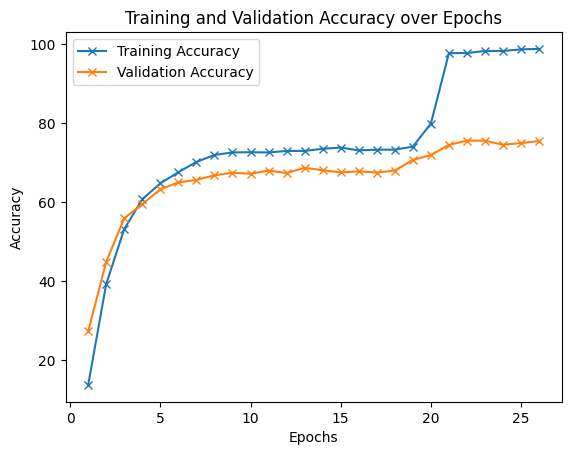

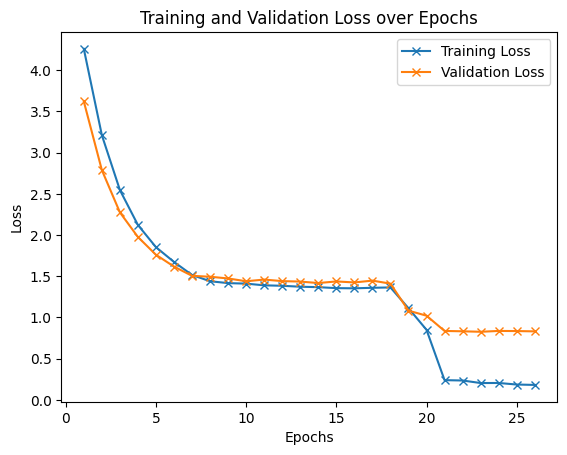

In [22]:
plot(acc_hist,'Training Accuracy','Validation Accuracy','Training and Validation Accuracy over Epochs','Epochs','Accuracy')

plot(loss_hist,'Training Loss','Validation Loss','Training and Validation Loss over Epochs','Epochs','Loss')

In [23]:

# Utilisation de la fonction pour tracer l'exactitude
plot(acc_hist, 'Training Accuracy', 'Validation Accuracy', 'Training and Validation Accuracy over Epochs', 'Epochs', 'Accuracy')

# Utilisation de la fonction pour tracer la perte
plot(loss_hist, 'Training Loss', 'Validation Loss', 'Training and Validation Loss over Epochs', 'Epochs', 'Loss')

# Tester le model

In [24]:
# Création d'un ensemble de données pour les tests
test_data = DogBreedsDataset(label_file, train_dir, data_transforms['test'])


In [25]:
# Création d'un DataLoader pour les données de test
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [27]:
# Évaluation du modèle sur l'ensemble de test
score = test(test_loader, model)


Test Accuracy: 93.76%


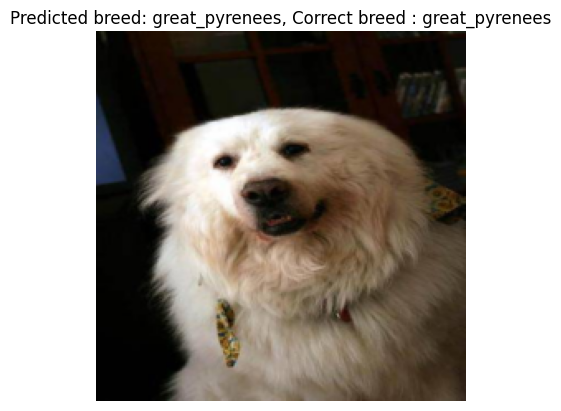

In [28]:
# Visualisation rapide de la prédiction pour une image spécifique dans l'ensemble de test
quickTest(test_loader, model, class_labels, 18)


# Telecharger le model

In [29]:
!ls

best_model.pth	best_modelv1.pth  model.zip


In [30]:
!zip -r model.zip best_modelv1.pth

updating: best_modelv1.pth (deflated 7%)


In [31]:
from IPython.display import FileLink
FileLink(r'model.zip')

/kaggle/working/model.zip